In [1]:
import scanpy as sc
import squidpy as sq
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
import copy

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
from algorithms import *
from data_gen import *
from spectrum_gen import *
from visualizations import *
from analysis import *
import os
from algorithms_torch import *
from data_gen import *
from datasets import *
import time


In [2]:
sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

# load the pre-processed dataset
adata = sq.datasets.slideseqv2()
adata

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.3 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.11 louvain==0.7.1 pynndescent==0.5.7
squidpy==1.2.2


AnnData object with n_obs × n_vars = 41786 × 4000
    obs: 'barcode', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'deconvolution_results', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [3]:
adata = sc.pp.subsample(adata, fraction=0.75, copy=True)

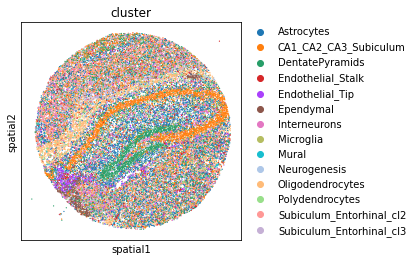

In [4]:
sc.pl.spatial(adata, color="cluster", spot_size=30)

In [5]:
sq.gr.spatial_neighbors(adata, n_rings=3, coord_type="grid" , n_neighs=10)



In [6]:
orig_adata = adata.copy()


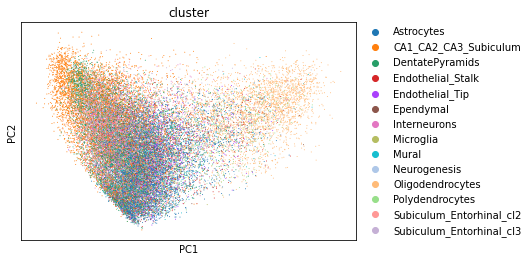

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


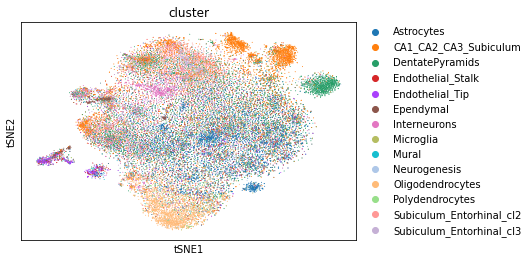

In [7]:
sc.tl.pca(orig_adata)
sc.pl.pca(orig_adata, color='cluster')
sc.tl.tsne(orig_adata)
sc.pl.tsne(orig_adata, color='cluster')


In [10]:
sq.gr.spatial_autocorr(orig_adata, mode="moran")
orig_adata.uns["moranI"].head(5)

,I,pval_norm,var_norm,pval_norm_fdr_bh
Ttr,0.682537,0.0,0.000001,0.0
Hpca,0.466606,0.0,0.000001,0.0
Mbp,0.419028,0.0,0.000001,0.0
Enpp2,0.402299,0.0,0.000001,0.0
Pcp4,0.389723,0.0,0.000001,0.0


In [11]:
adata_filtered_suerat = orig_adata.copy()

In [12]:
spatial_genes= (orig_adata.uns["moranI"]).index.values.tolist()[:50]

In [13]:
sc.tl.score_genes_cell_cycle(adata_filtered_suerat, s_genes=spatial_genes[:25], g2m_genes=spatial_genes[25:])

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [14]:
sc.pp.regress_out(adata_filtered_suerat, ['S_score', 'G2M_score'])

In [15]:
adata_filtered_suerat3 = adata_filtered_suerat[adata_filtered_suerat.obs['cluster'].isin(['Oligodendrocytes','Polydendrocytes'])]
calinski_harabasz_score(adata_filtered_suerat3.X,adata_filtered_suerat3.obs['cluster'])

44.49661074199579

In [16]:
adata_filtered_suerat3 = adata_filtered_suerat[adata_filtered_suerat.obs['cluster'].isin(["Endothelial_Tip", "Ependymal"])]
calinski_harabasz_score(adata_filtered_suerat3.X,adata_filtered_suerat3.obs['cluster'])

18.51077182958253

In [17]:
adata_filtered_suerat3 = adata_filtered_suerat[adata_filtered_suerat.obs['cluster'].isin(['Endothelial_Tip','Endothelial_Stalk'])]
calinski_harabasz_score(adata_filtered_suerat3.X,adata_filtered_suerat3.obs['cluster'])

26.132388495401987

In [18]:
adata_filtered_suerat = orig_adata.copy()

In [19]:
spatial_genes= (orig_adata.uns["moranI"]).index.values.tolist()[:100]

In [20]:
sc.tl.score_genes_cell_cycle(adata_filtered_suerat, s_genes=spatial_genes[:50], g2m_genes=spatial_genes[50:])

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [21]:
sc.pp.regress_out(adata_filtered_suerat, ['S_score', 'G2M_score'])

In [22]:
adata_filtered_suerat3 = adata_filtered_suerat[adata_filtered_suerat.obs['cluster'].isin(['Oligodendrocytes','Polydendrocytes'])]
calinski_harabasz_score(adata_filtered_suerat3.X,adata_filtered_suerat3.obs['cluster'])

47.859674202542486

In [23]:
adata_filtered_suerat3 = adata_filtered_suerat[adata_filtered_suerat.obs['cluster'].isin(["Endothelial_Tip", "Ependymal"])]
calinski_harabasz_score(adata_filtered_suerat3.X,adata_filtered_suerat3.obs['cluster'])

19.68608906395536

In [24]:
adata_filtered_suerat3 = adata_filtered_suerat[adata_filtered_suerat.obs['cluster'].isin(['Endothelial_Tip','Endothelial_Stalk'])]
calinski_harabasz_score(adata_filtered_suerat3.X,adata_filtered_suerat3.obs['cluster'])

26.015472503894333

In [25]:
adata_filtered_suerat = orig_adata.copy()

In [26]:
spatial_genes= (orig_adata.uns["moranI"]).index.values.tolist()[:150]

In [27]:
sc.tl.score_genes_cell_cycle(adata_filtered_suerat, s_genes=spatial_genes[:75], g2m_genes=spatial_genes[75:])

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [28]:
sc.pp.regress_out(adata_filtered_suerat, ['S_score', 'G2M_score'])

In [29]:
adata_filtered_suerat3 = adata_filtered_suerat[adata_filtered_suerat.obs['cluster'].isin(['Oligodendrocytes','Polydendrocytes'])]
calinski_harabasz_score(adata_filtered_suerat3.X,adata_filtered_suerat3.obs['cluster'])

72.77923023173504

In [30]:
adata_filtered_suerat3 = adata_filtered_suerat[adata_filtered_suerat.obs['cluster'].isin(["Endothelial_Tip", "Ependymal"])]
calinski_harabasz_score(adata_filtered_suerat3.X,adata_filtered_suerat3.obs['cluster'])

19.104023882140538

In [31]:
adata_filtered_suerat3 = adata_filtered_suerat[adata_filtered_suerat.obs['cluster'].isin(['Endothelial_Tip','Endothelial_Stalk'])]
calinski_harabasz_score(adata_filtered_suerat3.X,adata_filtered_suerat3.obs['cluster'])

25.443229520357463

In [39]:
adata_filtered_suerat = orig_adata.copy()
spatial_genes= (orig_adata.uns["moranI"]).index.values.tolist()[:500]

In [40]:
sc.tl.score_genes_cell_cycle(adata_filtered_suerat, s_genes=spatial_genes[:250], g2m_genes=spatial_genes[250:])
sc.pp.regress_out(adata_filtered_suerat, ['S_score', 'G2M_score'])
adata_filtered_suerat3 = adata_filtered_suerat[adata_filtered_suerat.obs['cluster'].isin(['Oligodendrocytes','Polydendrocytes'])]
calinski_harabasz_score(adata_filtered_suerat3.X,adata_filtered_suerat3.obs['cluster'])

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


158.72204886837537

In [41]:
orig_adatat3 = orig_adata[orig_adata.obs['cluster'].isin(['Endothelial_Tip', 'Ependymal'])]
calinski_harabasz_score(orig_adatat3.X.toarray(),orig_adatat3.obs['cluster'])

20.108244043097052

In [42]:
orig_adatat3 = orig_adata[orig_adata.obs['cluster'].isin(['Endothelial_Tip','Endothelial_Stalk'])]
calinski_harabasz_score(orig_adatat3.X.toarray(),orig_adatat3.obs['cluster'])

25.511776450886153